Load all necessary imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import matplotlib.pyplot as plt
import h5py
import wandb
import random


# Configure Keras to use GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

2024-03-27 12:08:22.341429: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-27 12:08:22.373362: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 12:08:22.373389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 12:08:22.374250: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-27 12:08:22.379719: I tensorflow/core/platform/cpu_feature_guar

### Data Loading and Preprocessing

In [2]:
## Load data
with h5py.File('TrainingData5zeroes.h5', 'r') as hdf:
    ls = list(hdf.keys())
    images = hdf.get('images')
    boxes = hdf.get('boxes')
    images = np.array(images)
    boxes = np.array(boxes)


## Normalize images and bounding boxes
    
image_normalized = (images+1e-9)/9.26 # Normalize images and add noise
# Normalize bounding boxes
normalized_boxes = boxes / [1,64,64,64,64]





images_np = image_normalized
#images_np = tf.expand_dims(images_np, axis=-1)
probabilities = np.array(normalized_boxes[:, :,:-4])
probabilities = tf.expand_dims(probabilities, axis=1)
boxes_np = np.array(normalized_boxes[:, :, 1:])
boxes_np = tf.expand_dims(boxes_np, axis=1)

dataset = tf.data.Dataset.from_tensor_slices((images_np,{'x_prob_reshape':probabilities,'x_boxes_reshape':boxes_np}))
dataset = dataset.shuffle(buffer_size=10000,reshuffle_each_iteration=True)
dataset = dataset.batch(128)

2024-03-27 12:08:30.382913: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21918 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


Model Train


In [29]:

# input_shape = (64,64,1)
# num_classes = 280
# num_coordinates = 4

# x_input = layers.Input(shape=input_shape)
# #Layer 1
# x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
# x = layers.MaxPool2D()(x)
# x = layers.BatchNormalization()(x) 
# x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
# #Layer 2
# x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
# x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
# #Layer 3
# x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
# x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
# #Layer 4
# x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
# x = layers.MaxPool2D()(x)
# x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
# x = layers.MaxPool2D()(x)
# x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
# x = layers.MaxPool2D()(x)
# #Layer 5
# x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
# x = layers.MaxPool2D()(x)
# x = layers.BatchNormalization()(x) 


# x = layers.Flatten()(x)
# # Probability output
# x_prob = layers.Dense(num_classes, activation='sigmoid', name='x_prob')(x)
# x_prob_reshape = layers.Reshape((-1, num_classes, 1), name='x_prob_reshape')(x_prob)

# # Bounding box output
# x_boxes = layers.Dense(num_classes * num_coordinates, activation='sigmoid', name='x_boxes')(x)
# x_boxes_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_boxes_reshape')(x_boxes)


# model = tf.keras.models.Model(x_input, [x_prob_reshape, x_boxes_reshape])
# optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5) 
# model.compile(optimizer= optimizer, loss= {'x_prob_reshape': tf.keras.losses.BinaryCrossentropy(), 'x_boxes_reshape':tf.keras.losses.MeanSquaredError()}, metrics={'x_prob_reshape': 'accuracy'} )
# num_epochs = 20


In [66]:
sweep_config = {
    'method': 'bayes'
    }
metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric
parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'fc_layer_size': {
        'values': [128, 512]
        },
    'dropout': {
          'values': [0.3, 0.5]
        },
    }

sweep_config['parameters'] = parameters_dict
parameters_dict.update({
    'epochs': {
        'value': 20}
    })
parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
      },
    'batch_size': {
        # integers between 32 and 256
        # with evenly-distributed logarithms 
        'distribution': 'q_log_uniform_values',
        'q': 8,
        'min': 32,
        'max': 256,
      }
    })

In [67]:
import pprint

pprint.pprint(sweep_config)

{'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch_size': {'distribution': 'q_log_uniform_values',
                               'max': 256,
                               'min': 32,
                               'q': 8},
                'dropout': {'values': [0.3, 0.5]},
                'epochs': {'value': 20},
                'fc_layer_size': {'values': [128, 512]},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.1,
                                  'min': 0},
                'optimizer': {'values': ['adam', 'sgd']}}}


In [68]:
sweep_id = wandb.sweep(sweep_config, project="M27 Hyperparameter Tuning")

Create sweep with ID: u52gex6s
Sweep URL: https://wandb.ai/alphanium/M27%20Hyperparameter%20Tuning/sweeps/u52gex6s


In [69]:

input_shape = (64,64,1)
num_classes = 280
num_coordinates = 4

x_input = layers.Input(shape=input_shape)
#Layer 1
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
#Layer 2
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
#Layer 3
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
#Layer 4
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
#Layer 5
x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 


x = layers.Flatten()(x)
# Probability output
x_prob = layers.Dense(num_classes, activation='sigmoid', name='x_prob')(x)
x_prob_reshape = layers.Reshape((-1, num_classes, 1), name='x_prob_reshape')(x_prob)

# Bounding box output
x_boxes = layers.Dense(num_classes * num_coordinates, activation='sigmoid', name='x_boxes')(x)
x_boxes_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_boxes_reshape')(x_boxes)


model = tf.keras.models.Model(x_input, [x_prob_reshape, x_boxes_reshape])
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5) 
model.compile(optimizer= optimizer, loss= {'x_prob_reshape': tf.keras.losses.BinaryCrossentropy(), 'x_boxes_reshape':tf.keras.losses.MeanSquaredError()}, metrics={'x_prob_reshape': 'accuracy'} )
num_epochs = 200


In [ ]:

# wandb.init(
#     # set the wandb project where this run will be logged
#     project="MyFirstComputerVision",
    
#     # track hyperparameters and run metadata
#     config={
#     "learning_rate": 3e-5,
#     "architecture": "model",
#     "dataset": "dataset",
#     "epochs": "num_epochs",
#     }
# )
# # simulate training

# offset = random.random() / 5
# for epoch in range(2,num_epochs):
#     acc = 1 - 2 ** -epoch - random.random() / epoch - offset
#     loss = 2 ** -epoch + random.random() / epoch + offset
    
#     # log metrics to wandb
#     wandb.log({"acc": acc, "loss": loss})
    
# # [optional] finish the wandb run, necessary in notebooks
# wandb.finish()

In [70]:
loaded_model = tf.keras.models.load_model('M11overfittedmodel3variant.h5')


In [9]:



# model.fit(
#     dataset,
#     epochs=num_epochs 
   
# )





In [71]:
class WandbCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None ):
        if logs is not None:
            # Logs will include loss and any other metrics like 'accuracy'
            wandb.log({'loss': logs['loss'], 'accuracy': logs['accuracy'], 'epoch': epoch})
            



In [72]:
def train():
    
    with wandb.init() as run:
        config = run.config
        
        model = loaded_model(config)
        model.fit(dataset, epochs= config.epochs, callbacks=[WandbCallback()])

wandb.agent(sweep_id, train, count=5)  # Run the sweep agent


wandb: Agent Starting Run: 7flu0duc with config:
wandb: 	batch_size: 40
wandb: 	dropout: 0.3
wandb: 	epochs: 20
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.020314130988976265
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Traceback (most recent call last):
  File "/tmp/ipykernel_74988/2274857445.py", line 6, in train
    model = loaded_model(config)
  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 213, in assert_input_compatibility
    raise TypeError(
TypeError: Inputs to a layer should be tensors. Got '{'batch_size': 40, 'dropout': 0.3, 'epochs': 20, 'fc_layer_size': 128, 'learning_rate': 0.020314130988976265, 'optimizer': 'sgd'}' (of type <class 'wandb.sdk.wandb_config.Config'>) as input for layer 'model'.


Run 7flu0duc errored:
Traceback (most recent call last):
  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_74988/2274857445.py", line 6, in train
    model = loaded_model(config)
  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 213, in assert_input_compatibility
    raise TypeError(
TypeError: Inputs to a layer should be tensors. Got '{'batch_size': 40, 'dropout': 0.3, 'epochs': 20, 'fc_layer_size': 128, 'learning_rate': 0.020314130988976265, 'optimizer': 'sgd'}' (of type <class 'wandb.sdk.wandb_config.Config'>) as input for layer 'model'.

wandb: ERROR Run 7flu0duc errored:
wandb: ERROR Traceback (most recen

Traceback (most recent call last):
  File "/tmp/ipykernel_74988/2274857445.py", line 6, in train
    model = loaded_model(config)
  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 213, in assert_input_compatibility
    raise TypeError(
TypeError: Inputs to a layer should be tensors. Got '{'batch_size': 144, 'dropout': 0.3, 'epochs': 20, 'fc_layer_size': 128, 'learning_rate': 0.07969606548741637, 'optimizer': 'sgd'}' (of type <class 'wandb.sdk.wandb_config.Config'>) as input for layer 'model'.


Run whmpf0p9 errored:
Traceback (most recent call last):
  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_74988/2274857445.py", line 6, in train
    model = loaded_model(config)
  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 213, in assert_input_compatibility
    raise TypeError(
TypeError: Inputs to a layer should be tensors. Got '{'batch_size': 144, 'dropout': 0.3, 'epochs': 20, 'fc_layer_size': 128, 'learning_rate': 0.07969606548741637, 'optimizer': 'sgd'}' (of type <class 'wandb.sdk.wandb_config.Config'>) as input for layer 'model'.

wandb: ERROR Run whmpf0p9 errored:
wandb: ERROR Traceback (most recen

Traceback (most recent call last):
  File "/tmp/ipykernel_74988/2274857445.py", line 6, in train
    model = loaded_model(config)
  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 213, in assert_input_compatibility
    raise TypeError(
TypeError: Inputs to a layer should be tensors. Got '{'batch_size': 112, 'dropout': 0.5, 'epochs': 20, 'fc_layer_size': 512, 'learning_rate': 0.005767155222856002, 'optimizer': 'sgd'}' (of type <class 'wandb.sdk.wandb_config.Config'>) as input for layer 'model'.


Run z2r7vzod errored:
Traceback (most recent call last):
  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_74988/2274857445.py", line 6, in train
    model = loaded_model(config)
  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 213, in assert_input_compatibility
    raise TypeError(
TypeError: Inputs to a layer should be tensors. Got '{'batch_size': 112, 'dropout': 0.5, 'epochs': 20, 'fc_layer_size': 512, 'learning_rate': 0.005767155222856002, 'optimizer': 'sgd'}' (of type <class 'wandb.sdk.wandb_config.Config'>) as input for layer 'model'.

wandb: ERROR Run z2r7vzod errored:
wandb: ERROR Traceback (most rece

In [30]:
#model.save('M11overfittedmodel3variant.h5')



In [31]:
#model.save('M11overfittedmodel3variant.keras')

In [31]:
boxes.shape

(10000, 280, 5)

In [32]:
dataset = tf.data.Dataset.from_tensor_slices((images_np,{'x_prob_reshape':probabilities,'x_boxes_reshape':boxes_np}))

# # Assuming dataset has 10,000 examples and we want an 80/20 split
# total_items = 10000
# train_size = int(total_items * 0.6)
# # val_size = total_items - train_size

# # Splitting the dataset
# train_dataset = dataset.take(train_size)
# # val_dataset = dataset.skip(train_size)


# # train_dataset = train_dataset.shuffle(buffer_size=train_size,reshuffle_each_iteration=True)
# train_dataset = train_dataset.batch(6000)
# inputs,targets = next(iter(train_dataset))
dataset = dataset.batch(10000)
inputs,targets = next(iter(dataset))
output = model.predict(inputs)

313/313 [==============================] - 3s 8ms/step


In [11]:
targets['x_boxes_reshape'][0]

<tf.Tensor: shape=(1, 280, 4), dtype=float64, numpy=
array([[[0.734375, 0.015625, 0.734375, 0.03125 ],
        [0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      ],
        ...,
        [0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      ]]])>

In [12]:
output[1][0]

array([[[7.24306941e-01, 3.01006213e-02, 7.41804957e-01, 3.33228447e-02],
        [2.24880949e-02, 7.51386629e-03, 2.32093632e-02, 7.64035154e-03],
        [4.27702442e-03, 6.26132824e-03, 4.65806713e-03, 6.90292520e-03],
        ...,
        [2.88477138e-04, 1.39197495e-04, 1.47837753e-04, 1.58194220e-04],
        [1.42245786e-04, 2.08800062e-04, 1.84095348e-04, 1.41638870e-04],
        [1.16996292e-04, 1.13774906e-04, 1.76820322e-04, 1.51523607e-04]]],
      dtype=float32)

In [33]:
import tensorflow as tf

r = np.random.randint(0,100)
tensor1 = tf.constant(targets['x_prob_reshape'], dtype=tf.float64)

tensor2 = tf.constant(output[0], dtype=tf.float32)


tensor2 = tf.cast(tensor2, tf.float64)


mse_loss_fn =  tf.keras.losses.BinaryCrossentropy()
mse_loss = mse_loss_fn(tensor1, tensor2)

print("MSE Loss:", mse_loss.numpy())


MSE Loss: 1.3558886642682864e-07


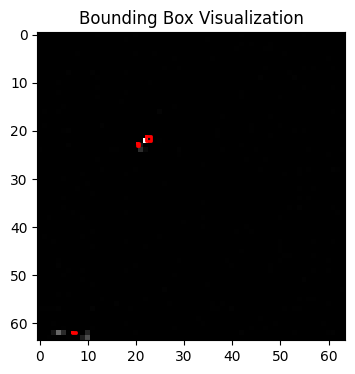

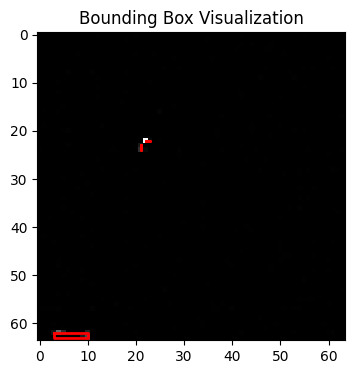

In [42]:
def visualize_bounding_boxes(image, probability_vector, bounding_box_coordinates, threshold=0.9):
    """
    Visualizes bounding boxes on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with bounding boxes.
    - bounding_box_coordinates: A 2D tensor representing bounding box coordinates.
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with bounding boxes).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    bbox_coordinates_np = bounding_box_coordinates
   # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Bounding Box Visualization")

    # Plot bounding boxes based on probability threshold
    for i in range(len(prob_vector_np)):
        prob = prob_vector_np[i]
        bbox = bbox_coordinates_np[i]
        if prob > threshold:
            # Denormalize bounding box coordinates if necessary
            denormalized_bbox = bbox  # Modify if normalization was applied during training
            y1, x1, y2, x2 = denormalized_bbox
            plt.plot([x1, x2, x2, x1, x1],[y1, y1, y2, y2, y1],
                     
                     color='r', linewidth=2, label='Bounding Box')

   






   
    plt.show()

t = np.random.randint(0,100)


visualize_bounding_boxes(tf.convert_to_tensor(inputs[t]), probabilities.numpy()[t].squeeze(), tf.convert_to_tensor(output[1][t,0,:,:])*[64,64,64,64]) ##myprediction
visualize_bounding_boxes(tf.convert_to_tensor(image_normalized[t]), probabilities.numpy()[t].squeeze(), tf.convert_to_tensor(boxes_np[t,0,:,:])*[64,64,64,64]) ##myprediction



